===== Market (last step) =====
t       = 100
q_t     = 0.0400
L_t     = 9999.98
C_t     = 4981.77
agent_0: K=1703.7, xI=0.0, xH=0.0, CumR=-39.140
agent_1: K=1000.7, xI=0.0, xH=0.0, CumR=-39.140
agent_2: K=1427.4, xI=0.0, xH=0.0, CumR=-39.140


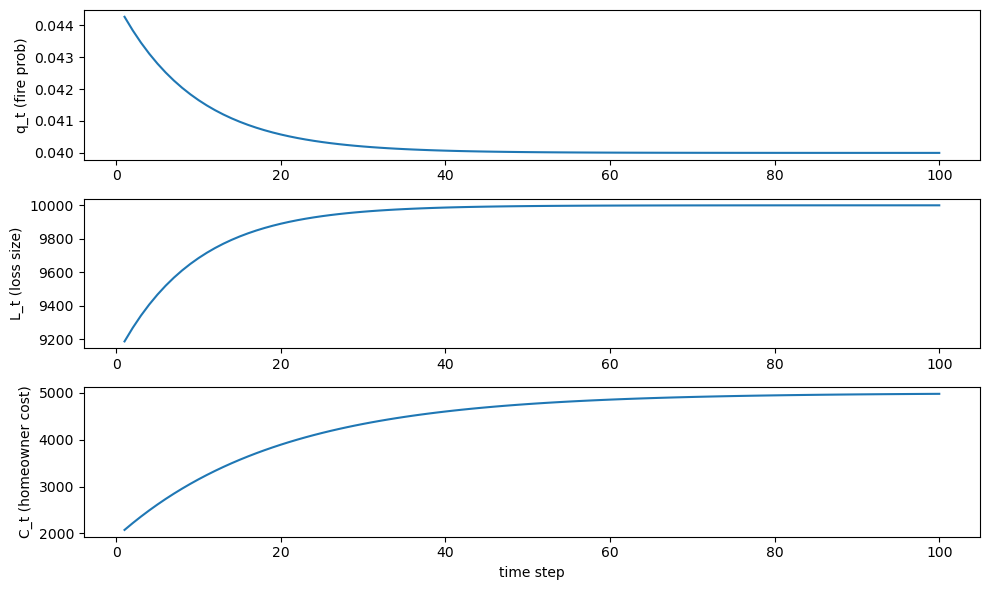

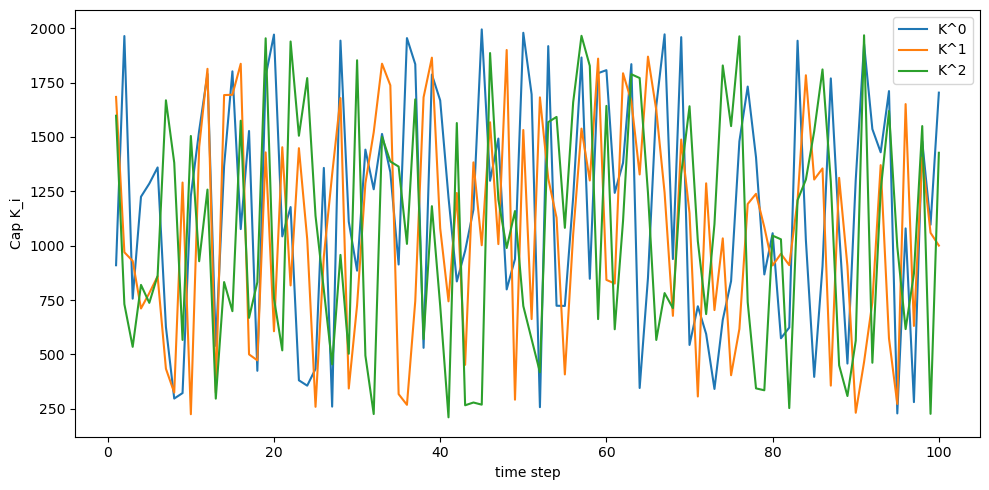

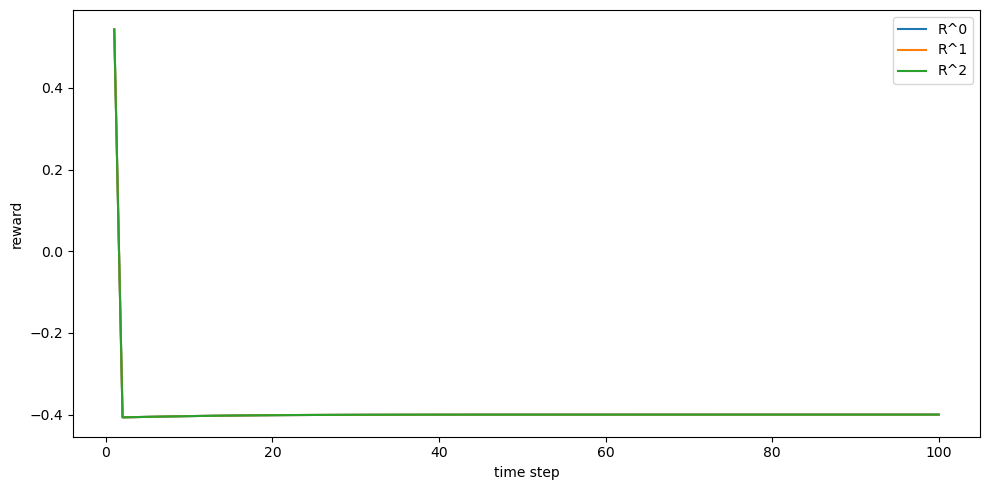

In [1]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt

class MultiAgentInsuranceEnv(gym.Env):
    """
    Multi-player / Multi-agent Environment
        obs:     {agent_id: obs_i}
        rewards: {agent_id: r_i}
        dones:   {agent_id: done, "__all__": done}
        infos:   {agent_id: {...}}
    """

    metadata = {"render.modes": ["human"]}

    def __init__(
        self,
        n_agents: int = 3,
        K_min: float = 200.0,
        K_max: float = 2000.0,
        max_steps: int = 200,
    ):
        super().__init__()

        self.n_agents = n_agents
        self.agent_ids = [f"agent_{i}" for i in range(self.n_agents)]

        # States: [q, L, C, T_i, X_i, xI_i, xH_i]
        obs_low_single = np.array(
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            dtype=np.float32,
        )
        obs_high_single = np.array(
            [1.0, 50000.0, 50000.0, 20000.0, 50.0, 1.0, 1.0],
            dtype=np.float32,
        )

        self.observation_space = spaces.Dict(
            {
                agent_id: spaces.Box(
                    low=obs_low_single,
                    high=obs_high_single,
                    dtype=np.float32,
                )
                for agent_id in self.agent_ids
            }
        )

        self.K_min = K_min
        self.K_max = K_max
        self.action_space = spaces.Dict(
            {
                agent_id: spaces.Box(
                    low=-1.0,
                    high=1.0,
                    shape=(1,),
                    dtype=np.float32,
                )
                for agent_id in self.agent_ids
            }
        )

        self.alpha_1 = 1.0  # insurance company
        self.alpha_2 = 1.0  # homeowner

        self.m = 250.0  # risk premium for Insurance Company

        self.q_bar = 0.04
        self.L_bar = 10000.0
        self.C_bar = 2500.0

        self.phi_q = 0.9
        self.phi_L = 0.9
        self.phi_C = 0.9

        self.sigma_q = 0.0
        self.sigma_L = 0.0
        self.sigma_C = 0.0

        self.gamma_T = 5.0
        self.gamma_X = 1.0
        self.rho_bar = 0.5  # goal coverage for homeowner

        self.max_steps = max_steps
        self.step_count = 0

        self.q = None
        self.L = None
        self.C = None

        self.T = None
        self.X = None
        self.xI = None
        self.xH = None

        self.cum_rewards = {agent_id: 0.0 for agent_id in self.agent_ids}
        self.q_traj = []
        self.L_traj = []
        self.C_traj = []
        self.K_traj = []
        self.xI_traj = []
        self.xH_traj = []
        self.reward_traj = []


    def seed(self, seed=None):
        np.random.seed(seed)

    def _get_obs(self):
        obs = {}
        for idx, agent_id in enumerate(self.agent_ids):
            obs[agent_id] = np.array(
                [
                    self.q,
                    self.L,
                    self.C,
                    self.T[idx],
                    self.X[idx],
                    self.xI[idx],
                    self.xH[idx],
                ],
                dtype=np.float32,
            )
        return obs

    # ------------------------------------------------------------------
    # Gym API
    # ------------------------------------------------------------------
    def reset(self):
        self.step_count = 0

        q_0 = np.clip(np.random.normal(self.q_bar, 0.005), 0.001, 0.2)
        L_0 = np.random.normal(self.L_bar, 1000.0)
        C_0 = np.random.normal(self.C_bar, 300.0)

        self.q = float(q_0)
        self.L = float(L_0)
        self.C = float(C_0)

        self.T = np.full(self.n_agents, 50.0, dtype=np.float32)
        self.X = np.full(self.n_agents, 300.0, dtype=np.float32)
        self.xI = np.zeros(self.n_agents, dtype=np.float32)
        self.xH = np.zeros(self.n_agents, dtype=np.float32)

        self.cum_rewards = {agent_id: 0.0 for agent_id in self.agent_ids}
        self.q_traj = []
        self.L_traj = []
        self.C_traj = []
        self.K_traj = []
        self.xI_traj = []
        self.xH_traj = []
        self.reward_traj = []

        return self._get_obs()

    def step(self, action_dict):
        """
        action_dict: {agent_id: np.array([a_i])},  a_i in [-1, 1]

        return:
            obs_dict, reward_dict, done_dict, info_dict
        """
        self.step_count += 1

        rewards = {}
        infos = {}

        K_list = np.zeros(self.n_agents, dtype=np.float32)
        for idx, agent_id in enumerate(self.agent_ids):
            a = float(np.clip(action_dict[agent_id][0], -1.0, 1.0))
            K_i = self.K_min + (a + 1.0) * 0.5 * (self.K_max - self.K_min)
            K_list[idx] = K_i

        new_T = np.zeros_like(self.T)
        new_X = np.zeros_like(self.X)
        new_xI = np.zeros_like(self.xI)
        new_xH = np.zeros_like(self.xH)

        up_ratio = 0.05
        down_ratio = 0.03

        for idx, agent_id in enumerate(self.agent_ids):
            K_i = K_list[idx]

            P_i = min(K_i, self.q * self.C + self.m)

            desire_buy = 1.0 if P_i <= (self.q * self.C + self.X[idx]) else 0.0

            exp_profit_if_buy = desire_buy * (P_i - self.q * self.C) - self.T[idx]

            if exp_profit_if_buy >= 0.0:
                xI_next = 1.0
                xH_next = desire_buy
            else:
                xI_next = 0.0
                xH_next = 0.0

            U_I = xI_next * (xH_next * (P_i - self.q * self.C) - self.T[idx])
            U_H = xI_next * xH_next * (self.q * self.C - P_i + self.X[idx]) - self.q * self.L

            reward = self.alpha_1 * U_I + self.alpha_2 * U_H
            reward /= 1000.0
            reward += 0.5 * xI_next
            reward += 0.2 * xH_next

            rewards[agent_id] = float(reward)
            self.cum_rewards[agent_id] += float(reward)

            T_next = self.T[idx] + self.gamma_T * (1.0 - xI_next)
            X_next = self.X[idx] + self.gamma_X * (xH_next - self.rho_bar)
            X_next = float(np.clip(X_next, 0.0, 50.0))

            new_T[idx] = T_next
            new_X[idx] = X_next
            new_xI[idx] = xI_next
            new_xH[idx] = xH_next

            infos[agent_id] = {
                "K_t": K_i,
                "P_t": P_i,
                "xI_next": xI_next,
                "xH_next": xH_next,
                "U_I": U_I,
                "U_H": U_H,
                "exp_profit_if_buy": exp_profit_if_buy,
            }

        q_next = self.phi_q * self.q + (1.0 - self.phi_q) * self.q_bar + self.sigma_q * np.random.randn()
        q_next = float(np.clip(q_next, 0.001, 0.5))

        L_next = self.phi_L * self.L + (1.0 - self.phi_L) * self.L_bar + self.sigma_L * np.random.randn()
        L_next = float(max(100.0, L_next))

        C_base = self.phi_C * self.C + (1.0 - self.phi_C) * self.C_bar

        xI_bar = float(np.mean(new_xI))
        if xI_bar < 1e-6:
            C_next = C_base + up_ratio * self.C
        else:
            C_next = C_base - down_ratio * self.C * xI_bar

        if self.sigma_C > 0.0:
            C_next += self.sigma_C * np.random.randn()

        C_next = float(max(100.0, C_next))

        self.q, self.L, self.C = q_next, L_next, C_next
        self.T, self.X, self.xI, self.xH = new_T, new_X, new_xI, new_xH

        self.q_traj.append(self.q)
        self.L_traj.append(self.L)
        self.C_traj.append(self.C)
        self.K_traj.append(K_list.copy())
        self.xI_traj.append(new_xI.copy())
        self.xH_traj.append(new_xH.copy())
        self.reward_traj.append(np.array([rewards[a] for a in self.agent_ids], dtype=np.float32))

        done = self.step_count >= self.max_steps
        dones = {agent_id: done for agent_id in self.agent_ids}
        dones["__all__"] = done

        obs = self._get_obs()
        return obs, rewards, dones, infos

    # ------------------------------------------------------------------
    # Graph
    # ------------------------------------------------------------------
    def plot_history(self, show=True, save_path=None):
        if len(self.q_traj) == 0:
            print("No history to plot. Run at least one episode first.")
            return

        steps = np.arange(1, len(self.q_traj) + 1)

        plt.figure(figsize=(10, 6))
        plt.subplot(3, 1, 1)
        plt.plot(steps, self.q_traj)
        plt.ylabel("q_t (fire prob)")

        plt.subplot(3, 1, 2)
        plt.plot(steps, self.L_traj)
        plt.ylabel("L_t (loss size)")

        plt.subplot(3, 1, 3)
        plt.plot(steps, self.C_traj)
        plt.ylabel("C_t (homeowner cost)")
        plt.xlabel("time step")
        plt.tight_layout()

        K_array = np.stack(self.K_traj, axis=0)  # [T, n_agents]
        plt.figure(figsize=(10, 5))
        for i in range(self.n_agents):
            plt.plot(steps, K_array[:, i], label=f"K^{i}")
        plt.xlabel("time step")
        plt.ylabel("Cap K_i")
        plt.legend()
        plt.tight_layout()

        reward_array = np.stack(self.reward_traj, axis=0)  # [T, n_agents]
        plt.figure(figsize=(10, 5))
        for i in range(self.n_agents):
            plt.plot(steps, reward_array[:, i], label=f"R^{i}")
        plt.xlabel("time step")
        plt.ylabel("reward")
        plt.legend()
        plt.tight_layout()

        if save_path is not None:
            plt.savefig(save_path)

        if show:
            plt.show()
        else:
            plt.close("all")

    # ------------------------------------------------------------------
    # render
    # ------------------------------------------------------------------
    def render(self, mode="human"):
        if len(self.q_traj) == 0:
            print("No history to render. Run at least one step.")
            return

        print("===== Market (last step) =====")
        print(f"t       = {self.step_count}")
        print(f"q_t     = {self.q:.4f}")
        print(f"L_t     = {self.L:.2f}")
        print(f"C_t     = {self.C:.2f}")

        K_last = self.K_traj[-1]
        xI_last = self.xI_traj[-1]
        xH_last = self.xH_traj[-1]

        for i, agent_id in enumerate(self.agent_ids):
            print(
                f"{agent_id}: K={K_last[i]:.1f}, "
                f"xI={xI_last[i]:.1f}, xH={xH_last[i]:.1f}, "
                f"CumR={self.cum_rewards[agent_id]:.3f}"
            )
        print("===============================")


if __name__ == "__main__":
    env = MultiAgentInsuranceEnv(n_agents=3, max_steps=100)
    obs = env.reset()

    done_all = False
    while not done_all:
        actions = {
            agent_id: env.action_space[agent_id].sample()
            for agent_id in env.agent_ids
        }
        obs, rewards, dones, infos = env.step(actions)
        done_all = dones["__all__"]

    env.render()
    env.plot_history()